In [2]:
import numpy as np
import pandas as pd
import os
import glob
import shutil
from tensorflow import keras
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from keras.layers import Dense, LSTM
from keras.models import Sequential
from keras.layers import Masking
import keras_tuner as kt
from pathlib import Path
import joblib # for saving and loading variables
import io
import contextlib
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, balanced_accuracy_score

In [26]:
base_folder = Path('C:/Users/ilkele4s/')

main_results_folder = 'ML_Results'
new_results_folder = 'LSTM_stratified_allElectrodes_results'

data_folder = 'Data'
data_file = 'All_Electrodes_data.csv'

tune_folder = 'Tune'
project_name = 'Random'

In [27]:
results_dir = os.path.join(base_folder,main_results_folder)

new_results_dir = os.path.join(results_dir,new_results_folder)

In [ ]:
os.mkdir(new_results_dir)

print(new_results_dir)

In [28]:
tune_dir = os.path.join(new_results_dir,tune_folder)

In [ ]:

# load the data 
data_dir = os.path.join(base_folder,data_folder)

data_file_path = os.path.join(data_dir,data_file)

print(data_file_path)

Data = pd.read_csv(data_file_path, header = None)

In [10]:
# structure samples for LSTM

data_array = np.array(Data)

n_samples = data_array.shape[0]
n_features = data_array.shape[1]

bin_cur = 1
bin_past = 3

bins_predict = bin_cur + bin_past # 3 previous + 1 current

formatted_data = np.zeros([n_samples,bins_predict,n_features])

start_idx=0
for i in range(n_samples-bin_past):
    end_idx=start_idx+bins_predict
    formatted_data[i+bin_past,:,:]=data_array[start_idx:end_idx,:]
    start_idx=start_idx+1

In [ ]:
# create a label set

n_zones = 45
n_trials = 32


cat_zones = keras.utils.to_categorical(np.r_[1:n_zones+1] ,num_classes=46)
cat_zones = np.delete(cat_zones,0,1)
labels_all_trials = np.tile(cat_zones, 32)

reshaped_labels_all_trials = np.reshape(labels_all_trials, [1440,45])



In [ ]:
np.shape(formatted_data)

In [ ]:
formatted_data[np.isnan(formatted_data)] = 0

In [ ]:
# train - test split

train_samples, test_samples, train_labels, test_labels = train_test_split(formatted_data, reshaped_labels_all_trials, test_size=0.20, stratify=reshaped_labels_all_trials, random_state=42)

In [ ]:
train_size = np.shape(train_samples)
test_size = np.shape(test_samples)
split_size =1/(train_size[0]/ test_size[0])
print(split_size)

In [ ]:
train_samples, validation_samples, train_labels, validation_labels, = train_test_split(train_samples, train_labels, test_size=.25, stratify=train_labels, random_state=42)

In [ ]:
print(np.shape(test_samples))
print(np.shape(train_samples))
print(np.shape(validation_samples))

print(np.shape(test_labels))
print(np.shape(train_labels))
print(np.shape(validation_labels))

In [ ]:
joblib.dump(train_samples, os.path.join(new_results_dir,'train_samples.sav'))
joblib.dump(train_labels, os.path.join(new_results_dir,'train_labels.sav'))

joblib.dump(test_samples, os.path.join(new_results_dir,'test_samples.sav'))
joblib.dump(test_labels, os.path.join(new_results_dir,'test_labels.sav'))

joblib.dump(validation_samples, os.path.join(new_results_dir,'validation_samples.sav'))
joblib.dump(validation_labels, os.path.join(new_results_dir,'validation_labels.sav'))

In [17]:
class MyHyperModel(kt.HyperModel):

    def build(self,hp):
        
            LSTM_units = [30, 40, 50]
            Drop_rate = [.20, .30, .40]
            RecDrop_rate = [.20, .30, .40]
            learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

            model=Sequential()
            model.add(Masking(mask_value=0, input_shape=(4, 17400))),
            model.add(LSTM(hp.Choice('LSTM_units',LSTM_units),                
                           input_shape=(4, 17400), 
                           dropout=hp.Choice('Drop_rate',Drop_rate),
                           recurrent_dropout=hp.Choice('RecDrop_rate', RecDrop_rate)))

            model.add(Dense(45, activation='softmax'))
            model.compile(loss='categorical_crossentropy',optimizer=keras.optimizers.Adam(learning_rate=learning_rate),metrics=['accuracy'])

            return model 
        
    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            # Tune whether to shuffle the data in each epoch.
            shuffle=hp.Boolean("shuffle"),
            **kwargs,
        )




In [18]:
#tuner = kt.GridSearch(
#    MyHyperModel(),
#    objective =kt.Objective("val_loss", direction="min"),
#    overwrite=True,
#    directory=NewDirectory ,
#    project_name="tune_hypermodel",
#)



In [19]:
tuner = kt.RandomSearch(
    MyHyperModel(),
    objective =kt.Objective("val_loss", direction="min"),
    overwrite=True,
    max_trials=30,
    directory= tune_dir ,
    project_name=project_name,
)


In [20]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
LSTM_units (Choice)
{'default': 30, 'conditions': [], 'values': [30, 40, 50], 'ordered': True}
Drop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}
RecDrop_rate (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.3, 0.4], 'ordered': True}


In [21]:
tuner.search(train_samples, train_labels, epochs=20, validation_data=(validation_samples, validation_labels))

Trial 30 Complete [00h 02m 08s]
val_loss: 0.9532785415649414

Best val_loss So Far: 0.8854193091392517
Total elapsed time: 01h 16m 33s
INFO:tensorflow:Oracle triggered exit


In [22]:
tuner.results_summary(num_trials=3)


Results summary
Results in C:\Users\ilkele4s\ML_Results\LSTM_stratified_allElectrodes_results\Tune\tune_hypermodel_random
Showing 3 best trials
Objective(name="val_loss", direction="min")

Trial 27 summary
Hyperparameters:
lr: 0.0004377992596146039
LSTM_units: 50
Drop_rate: 0.2
RecDrop_rate: 0.3
shuffle: False
Score: 0.8854193091392517

Trial 15 summary
Hyperparameters:
lr: 0.001370856638680745
LSTM_units: 50
Drop_rate: 0.3
RecDrop_rate: 0.3
shuffle: True
Score: 0.8863964080810547

Trial 24 summary
Hyperparameters:
lr: 0.0006318189784325001
LSTM_units: 40
Drop_rate: 0.4
RecDrop_rate: 0.4
shuffle: False
Score: 0.9184414744377136


In [22]:
# Capture the printed output using io.StringIO
summary_output = io.StringIO()

# Use contextlib.redirect_stdout to redirect the print output to the StringIO object
with contextlib.redirect_stdout(summary_output):
    tuner.results_summary(num_trials=3)

# Get the captured output
summary_text = summary_output.getvalue()


In [24]:
file = open(os.path.join(new_results_dir,'best_3params.txt'), 'w')
# Write content to the file
file.write(summary_text)

636

In [23]:
# Define a pattern to match files with names like "trial1", "trial2", etc.

to_remove = os.path.join(tune_dir, project_name)
pattern = "trial*"

# Use glob to find matching files
matching_files = glob.glob(os.path.join(to_remove, pattern))

# Iterate over matching files and delete them
for file_path in matching_files:
    try:
        shutil.rmtree(file_path)
        print(f"File '{file_path}' deleted successfully.")
    except OSError as e:
        print(f"Error deleting '{file_path}': {e}")

In [24]:
best_hp = tuner.get_best_hyperparameters()[0]

NameError: name 'tuner' is not defined

In [25]:
joblib.dump(best_hp, os.path.join(new_results_dir,'best_hyperparameters.sav'))

['C:\\Users\\ilkele4s\\ML_Results\\LSTM_stratified_allElectrodes_results\\best_hyperparameters.sav']

In [26]:
model = MyHyperModel()

# building the model
best_model = model.build(best_hp)

# training the model
best_model_trained = model.fit(best_hp, best_model, train_samples, 
                               train_labels,validation_data=(validation_samples, validation_labels), epochs=30)

Epoch 1/30
27/27 [==============================] - 10s 263ms/step - loss: 3.6209 - accuracy: 0.1562 - val_loss: 3.3217 - val_accuracy: 0.4028
Epoch 2/30
27/27 [==============================] - 7s 261ms/step - loss: 2.7096 - accuracy: 0.7014 - val_loss: 2.7528 - val_accuracy: 0.6181
Epoch 3/30
27/27 [==============================] - 7s 251ms/step - loss: 2.0976 - accuracy: 0.8669 - val_loss: 2.3980 - val_accuracy: 0.7222
Epoch 4/30
27/27 [==============================] - 7s 246ms/step - loss: 1.6763 - accuracy: 0.9167 - val_loss: 2.1181 - val_accuracy: 0.7882
Epoch 5/30
27/27 [==============================] - 7s 253ms/step - loss: 1.3992 - accuracy: 0.9479 - val_loss: 1.8800 - val_accuracy: 0.8368
Epoch 6/30
27/27 [==============================] - 7s 250ms/step - loss: 1.1803 - accuracy: 0.9583 - val_loss: 1.7007 - val_accuracy: 0.8611
Epoch 7/30
27/27 [==============================] - 7s 256ms/step - loss: 1.0116 - accuracy: 0.9688 - val_loss: 1.5767 - val_accuracy: 0.8819
Epoch

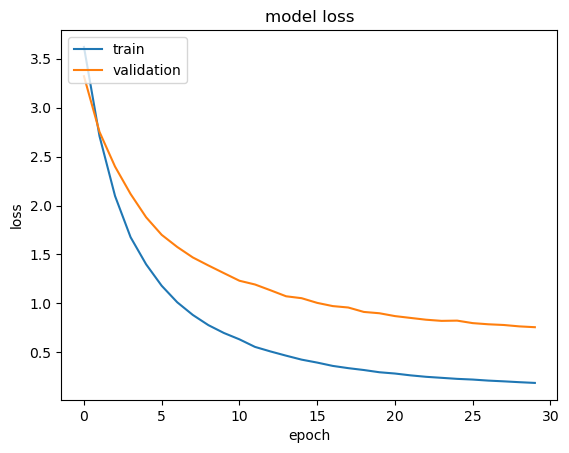

In [27]:
plt.plot(best_model_trained.history['loss'])
plt.plot(best_model_trained.history['val_loss'])

plt.legend(['train', 'validation'], loc='upper left')

ay = plt.gca()

ay.yaxis.set_major_locator(MultipleLocator(base=0.50)) 


plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')

plt.savefig(os.path.join(new_results_dir,'Model_loss.png'))
plt.show()

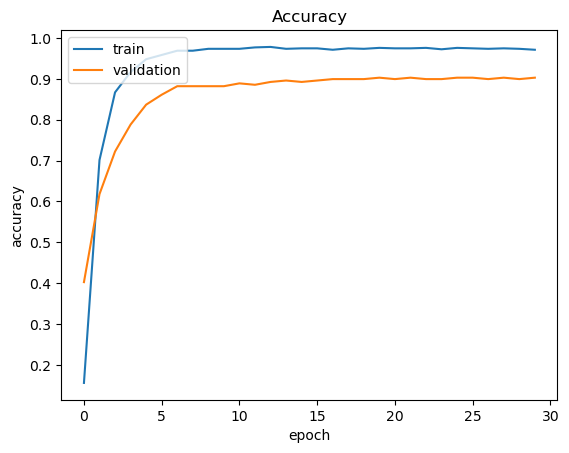

In [28]:
plt.plot(best_model_trained.history['accuracy'])
plt.plot(best_model_trained.history['val_accuracy'])


ay = plt.gca()
ay.yaxis.set_major_locator(MultipleLocator(base=0.10)) 

plt.legend(['train', 'validation'], loc='upper left')

plt.title('Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')

plt.savefig(os.path.join(new_results_dir,'Model_accuracy.png'))
plt.show()

In [30]:
predictions = best_model.predict(test_samples)

predicted_labels = np.argmax(predictions, axis=1) + 1

true_label = np.argmax(test_labels, axis=1) + 1

9/9 [==============================] - 1s 51ms/step


In [31]:
joblib.dump(predictions, os.path.join(new_results_dir,'predictions.sav'))

['C:\\Users\\ilkele4s\\ML_Results\\LSTM_stratified_allElectrodes_results\\predictions.sav']

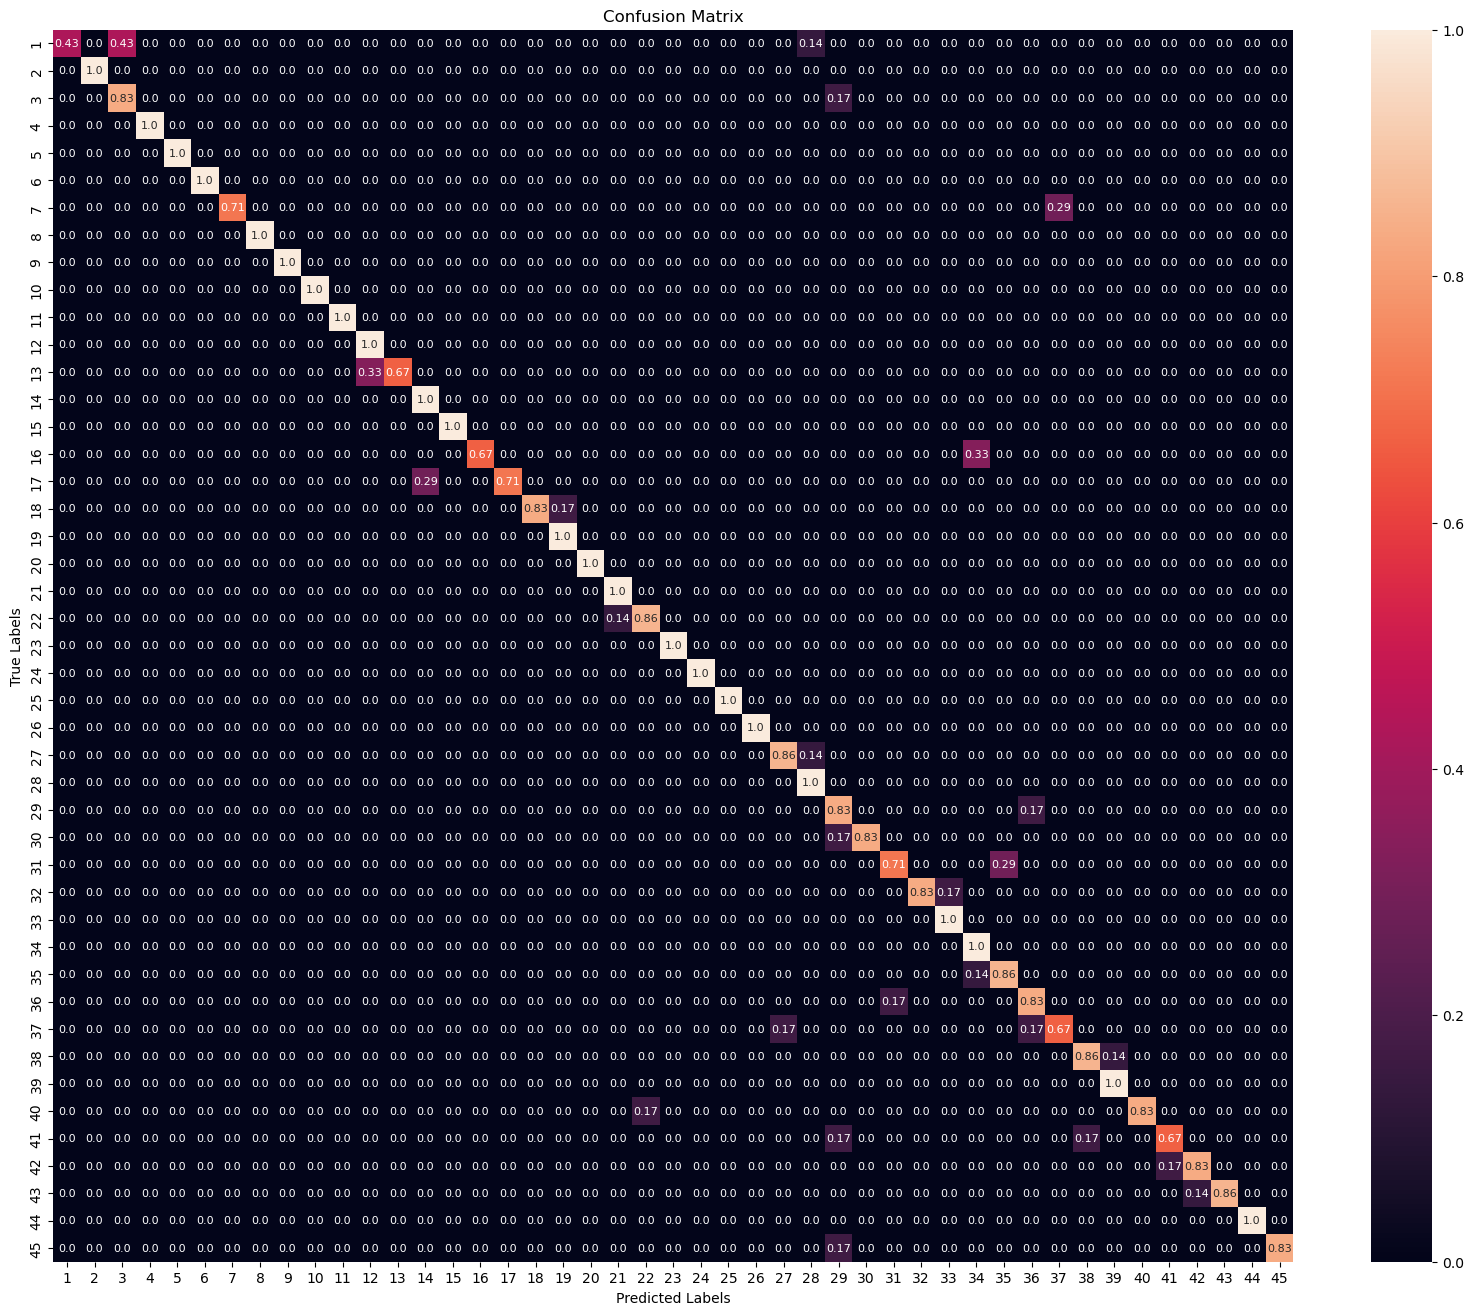

In [32]:
#%%
cm = confusion_matrix(true_label, predicted_labels, normalize='true')
#%%
class_labels = [str(i) for i in range(1, 46)]
#%%
plt.figure(figsize=(20, 16))
sns.heatmap(cm, fmt='.2',annot=True, annot_kws={"size": 8}, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

plt.savefig(os.path.join(new_results_dir,'Cm_optim.png'))
plt.show()

In [33]:
report = classification_report(true_label, predicted_labels, output_dict=True)

In [38]:
file = open(os.path.join(new_results_dir,'F1.txt'), 'w')
# Write content to the file
file.write(str(f1))

111

In [39]:
Acc = balanced_accuracy_score(true_label, predicted_labels)
print(Acc)

0.8894179894179893


In [40]:
file = open(os.path.join(new_results_dir,'Acc_balanced.txt'), 'w')
# Write content to the file
file.write(str(Acc))
file.close()